In [1]:
import faiss # make faiss available
import numpy as np
import json
import random
from PIL import Image
import matplotlib.pyplot as plt
import time
import pandas as pd 
import json
%matplotlib inline

In [2]:
image_paths=[]
with open("../image-files/geological_map.json", 'r', encoding='utf-8') as f:
    image_paths=json.load(f)
print(len(image_paths))

embedding = np.load("../encoders/geological_embed.npy")

29998


In [30]:
random_img_index=random.randint(0, len(image_paths)-1)
xq=embedding[random_img_index]
xb=embedding
print(xb.shape)
print(xq.shape)
xq=np.reshape(xq, (1, 576))
print(xq.shape)

(29998, 576)
(576,)
(1, 576)


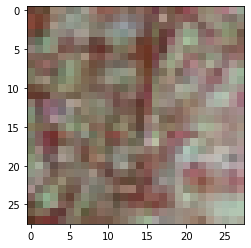

In [31]:
input_image_path=image_paths[random_img_index]
input_img = Image.open("../"+input_image_path).convert("RGB")
plt.imshow(input_img)
plt.show()

In [32]:
index = faiss.IndexFlatL2(576)# build the index
print(index.is_trained)
index.add(xb)                  # add vectors to the index
print(index.ntotal)
k=10
Dist, Indices = index.search(xq, k)     # actual search
print(Indices)                   # neighbors of the 5 first queries


True
29998
[[10014 12923 14736 14488 11303 13910 11493 11562 12346 12030]]


In [ ]:
indices = Indices[0]
print("total indices: ", len(indices))
for index in indices:
    # img_name = str(index - 1) + ".jpg"
    # print(img_name)
    img_path = image_paths[index]
    print(img_path)
    img = Image.open("../"+img_path).convert("RGB")
    plt.imshow(img)
    plt.show()

In [ ]:
#IVF-L2
import time
nlist = 100
k = 100
quantizer = faiss.IndexFlatL2(576)  # the other index
index = faiss.IndexIVFFlat(quantizer, 576, nlist, faiss.METRIC_L2)
# here we specify METRIC_L2, by default it performs inner-product search

assert not index.is_trained
index.train(xb)
assert index.is_trained

index.add(xb)                  # add may be a bit slower as well

start=time.time()
D, I = index.search(xq, k)     # actual search
# print(I[-5:])# neighbors of the 5 last queries
end=time.time()
print(end-start)
print(I)
index.nprobe = 10 # default nprobe is 1, try a few more
start=time.time()
D, I = index.search(xq, k)
end=time.time()
print(end-start)
print(I)                  # neighbors of the 5 last queries

In [ ]:
indices = I[0]
print("total indices: ", len(indices))
for index in indices:
    # img_name = str(index - 1) + ".jpg"
    # print(img_name)
    img_path = image_paths[index]
    print(img_path)
    img = Image.open("../"+img_path).convert("RGB")
    plt.imshow(img)
    plt.show()

In [ ]:
import pandas as pd


In [9]:
df=pd.read_csv("../knn-results/cosine-results.csv")
df.head()

,testing_image,time_taken,indices_list,output_indices
0,../geological_similarity/schist/TEJ1Y.jpg,0.106924,NaN,"[25578, 25754, 29111, 29065, 26147, 29888, 252..."
1,../geological_similarity/marble/13P1E.jpg,0.068276,NaN,"[13641, 13191, 10152, 10489, 11181, 11653, 119..."
2,../geological_similarity/andesite/RRGXD.jpg,0.067910,NaN,"[17741, 2403, 4762, 149, 4965, 1685, 842, 1399..."
3,../geological_similarity/schist/PEVYX.jpg,0.068621,NaN,"[9801, 9209, 6398, 6674, 9056, 7528, 7636, 813..."
4,../geological_similarity/schist/66ZT7.jpg,0.067650,NaN,"[25855, 27277, 5806, 8640, 6559, 25850, 8451, ..."


In [3]:
for i, obj in enumerate(image_paths):
    image_paths[i]=obj.replace("\\", "/")
    image_paths[i]="../"+image_paths[i]


In [7]:
def create_index(xb, nlist=100, nprobe=1):
    nlist = 100
    quantizer = faiss.IndexFlatIP(576)  # the other index
    index = faiss.IndexIVFFlat(quantizer, 576, nlist)
    # here we specify METRIC_L2, by default it performs inner-product search

    assert not index.is_trained
    index.train(xb)
    assert index.is_trained

    index.add(xb)
    return index

In [11]:
def search_index(index, xq, k):
    start=time.time()
    D, I = index.search(xq, k)     # actual search
    end=time.time()
    total_time=end-start
    return total_time, D, I[0]

In [13]:
def IVF_search(k, results_df, nlist=100, nprobe=1,):
    xb=embedding
    start=time.time()
    index=create_index(xb, nlist, nprobe)
    end=time.time()
    time_index=end-start
    for i, obj in enumerate(df["testing_image"]):
        xq=embedding[image_paths.index(obj)]
        xq=np.reshape(xq, (1, 576))
        total_time, D, indices=search_index(index, xq, k)
        if len(indices)!=0:
            acc=len(list(set(indices).intersection(json.loads(df["output_indices"][i]))))/len(indices)
        else:
            acc=0
        results_df=results_df.append({"testing_image":obj, "nlist":nlist, "nprobe":nprobe, "search_time":total_time, "output_indices":indices, "acc":acc, "index_time":time_index}, ignore_index=True)
    return results_df

In [14]:
results={"testing_image":[], "nlist":[], "nprobe":[], "output_indices":[], "acc":[]}
results_df=pd.DataFrame(results)
results_df.head()

,testing_image,nlist,nprobe,output_indices,acc


In [24]:
nlist=[50, 100, 200, 400, 800, 1600]
nprobe=[1, 4, 8, 32, 64, 128, 256, 512, 1024]
for nl in nlist:
    for npr in nprobe:
        if npr>=nl:
            continue
        results_df=IVF_search(50,results_df, nl, npr)
        print(nl, npr, "done")
results_df.info()

50 1 done
50 4 done
50 8 done
50 32 done
100 1 done
100 4 done
100 8 done
100 32 done
100 64 done
200 1 done
200 4 done
200 8 done
200 32 done
200 64 done
200 128 done
400 1 done
400 4 done
400 8 done
400 32 done
400 64 done
400 128 done
400 256 done
800 1 done
800 4 done
800 8 done
800 32 done
800 64 done
800 128 done
800 256 done
800 512 done
1600 1 done
1600 4 done
1600 8 done
1600 32 done
1600 64 done
1600 128 done
1600 256 done
1600 512 done
1600 1024 done
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5100 entries, 0 to 5099
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   testing_image   5100 non-null   object 
 1   nlist           5100 non-null   float64
 2   nprobe          5100 non-null   float64
 3   output_indices  5100 non-null   object 
 4   acc             5100 non-null   float64
 5   index_time      5100 non-null   float64
 6   search_time     5100 non-null   float64
dtypes: float64(5), obj

In [20]:
results_df.describe()

,nlist,nprobe,acc,index_time,search_time
count,1200.000000,1200.0,1200.000000,1200.000000,1200.000000
mean,525.000000,1.0,0.189600,0.526250,0.018167
std,541.635924,0.0,0.161943,0.030765,0.003476
min,50.000000,1.0,0.000000,0.458995,0.009987
25%,100.000000,1.0,0.060000,0.518004,0.015003
50%,300.000000,1.0,0.120000,0.531001,0.017002
75%,800.000000,1.0,0.280000,0.544749,0.021005
max,1600.000000,1.0,0.620000,0.577000,0.027001


In [21]:
results_df[results_df["testing_image"]==results_df["testing_image"][1021]]

,testing_image,nlist,nprobe,output_indices,acc,index_time,search_time
21,../geological_similarity/gneiss/SKDTL.jpg,50.0,1.0,"[8944, 5935, 8062, 6018, 7259, 8096, 6356, 280...",0.18,0.479999,0.020003
121,../geological_similarity/gneiss/SKDTL.jpg,100.0,1.0,"[8944, 5935, 8062, 6018, 7259, 8096, 6356, 280...",0.18,0.529002,0.023003
221,../geological_similarity/gneiss/SKDTL.jpg,200.0,1.0,"[8944, 5935, 8062, 6018, 7259, 8096, 6356, 280...",0.18,0.529001,0.021987
321,../geological_similarity/gneiss/SKDTL.jpg,400.0,1.0,"[8944, 5935, 8062, 6018, 7259, 8096, 6356, 280...",0.18,0.547997,0.022002
421,../geological_similarity/gneiss/SKDTL.jpg,800.0,1.0,"[8944, 5935, 8062, 6018, 7259, 8096, 6356, 280...",0.18,0.543002,0.023000
521,../geological_similarity/gneiss/SKDTL.jpg,1600.0,1.0,"[8944, 5935, 8062, 6018, 7259, 8096, 6356, 280...",0.18,0.546991,0.021002
621,../geological_similarity/gneiss/SKDTL.jpg,50.0,1.0,"[8944, 5935, 8062, 6018, 7259, 8096, 6356, 280...",0.18,0.458995,0.019999
721,../geological_similarity/gneiss/SKDTL.jpg,100.0,1.0,"[8944, 5935, 8062, 6018, 7259, 8096, 6356, 280...",0.18,0.533000,0.020003
821,../geological_similarity/gneiss/SKDTL.jpg,200.0,1.0,"[8944, 5935, 8062, 6018, 7259, 8096, 6356, 280...",0.18,0.523005,0.020999
921,../geological_similarity/gneiss/SKDTL.jpg,400.0,1.0,"[8944, 5935, 8062, 6018, 7259, 8096, 6356, 280...",0.18,0.503001,0.022002


In [22]:
results_df.to_csv("../faiss-results/IP-faiss.csv", index=False)

In [12]:
nbits = 576*4  # resolution of bucketed vectors
# initialize index and add vectors
index = faiss.IndexLSH(576, nbits)
index.add(xb)
# and search
D, I = index.search(xq, 10)

NameError: name 'xb' is not defined

In [13]:
def create_LSHBuckets(xb, nbit_factor):
    nbits = 576*nbit_factor  # resolution of bucketed vectors
    # initialize index and add vectors
    index = faiss.IndexLSH(576, nbits)
    index.add(xb)
    return index

In [14]:
def LSH_search(k, results_df, nbit_factor):
    xb=embedding
    start=time.time()
    index=create_LSHBuckets(xb,nbit_factor)
    end=time.time()
    time_index=end-start
    for i, obj in enumerate(df["testing_image"]):
        xq=embedding[image_paths.index(obj)]
        xq=np.reshape(xq, (1, 576))
        total_time, D, indices=search_index(index, xq, k)
        if len(indices)!=0:
            acc=len(list(set(indices).intersection(json.loads(df["output_indices"][i]))))/len(indices)
        else:
            acc=0
        results_df=results_df.append({"testing_image":obj, "nbit-factor":nbit_factor, "search_time":total_time, "output_indices":indices, "acc":acc, "index_time":time_index}, ignore_index=True)
    return results_df

In [15]:
results={"testing_image":[], "output_indices":[], "acc":[]}
results_df=pd.DataFrame(results)
results_df.head()

,testing_image,output_indices,acc


In [16]:
nbit=[1, 2, 4, 8, 16, 32]
for nl in nbit:
    results_df=LSH_search(50,results_df, nl)
    print(nl, "done")
results_df.info()

1 done
2 done
4 done
8 done
16 done
32 done
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   testing_image   600 non-null    object 
 1   output_indices  600 non-null    object 
 2   acc             600 non-null    float64
 3   index_time      600 non-null    float64
 4   nbit-factor     600 non-null    float64
 5   search_time     600 non-null    float64
dtypes: float64(4), object(2)
memory usage: 28.2+ KB


In [17]:
results_df.describe()

,acc,index_time,nbit-factor,search_time
count,600.000000,600.000000,600.000000,600.000000
mean,0.264800,40.033086,10.500000,0.006673
std,0.167355,75.662970,10.837239,0.006457
min,0.000000,0.240999,1.000000,0.000000
25%,0.140000,0.542531,2.000000,0.001997
50%,0.240000,3.041725,6.000000,0.004001
75%,0.380000,25.393509,16.000000,0.009995
max,0.720000,207.938029,32.000000,0.023000


In [19]:
results_df[0:100]

,testing_image,output_indices,acc,index_time,nbit-factor,search_time
0,../geological_similarity/schist/TEJ1Y.jpg,"[29065, 25578, 26255, 28259, 28099, 27969, 294...",0.46,0.240999,1.0,0.000999
1,../geological_similarity/marble/13P1E.jpg,"[10152, 13641, 13701, 14765, 11181, 11653, 146...",0.26,0.240999,1.0,0.002003
2,../geological_similarity/andesite/RRGXD.jpg,"[3818, 1785, 18549, 18431, 656, 4586, 17895, 1...",0.00,0.240999,1.0,0.001002
3,../geological_similarity/schist/PEVYX.jpg,"[28534, 5792, 5526, 29677, 9393, 5555, 6945, 9...",0.04,0.240999,1.0,0.005002
4,../geological_similarity/schist/66ZT7.jpg,"[25850, 27277, 26241, 25477, 6172, 7293, 8871,...",0.28,0.240999,1.0,0.000000
...,...,...,...,...,...,...
95,../geological_similarity/schist/4CEIR.jpg,"[25598, 25772, 5323, 26937, 6703, 27968, 26778...",0.10,0.240999,1.0,0.000999
96,../geological_similarity/marble/WR9FH.jpg,"[14560, 11490, 12023, 10619, 10176, 11445, 148...",0.44,0.240999,1.0,0.001988
97,../geological_similarity/marble/TCUV3.jpg,"[14135, 14332, 11665, 12068, 14151, 14011, 141...",0.18,0.240999,1.0,0.002000
98,../geological_similarity/rhyolite/N7T32.jpg,"[23299, 21121, 7290, 20852, 24562, 25166, 2774...",0.00,0.240999,1.0,0.001000


In [ ]:
results_df.to_csv("../LSH-results/LSH-faiss.csv", index=False)